Regression & ANOVA

1.查看資料集
2.敘述統計-繪圖
3.迴歸分析
4.變異數分析(ANOVA)
5.總結

1. 查看資料集
這裡使用的資料，是kaggle的健康保險費用資料，https://www.kaggle.com/mirichoi0218/insurance

In [30]:
import matplotlib as plt
import numpy as np
import pandas as pd

In [31]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [32]:
x = df.drop(["charges"], axis=1)
y = df["charges"]
x = pd.get_dummies(x, drop_first = True)
x.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


In [33]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


2. 敘述統計-繪圖

在進行資料分析之前，先仔細觀察資料，看看能不能從裡面找到一些隱藏資訊

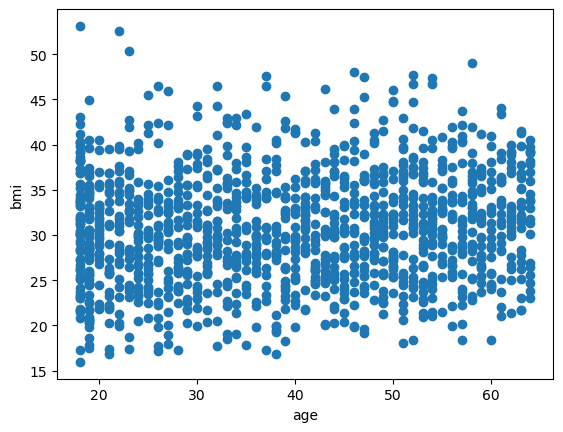

In [36]:
import matplotlib.pyplot as plt

plt.xlabel("age")
plt.ylabel("bmi")
plt.scatter(df["age"],df["bmi"])
plt.show()

嗯…好像看不出什麼東西，繼續找找

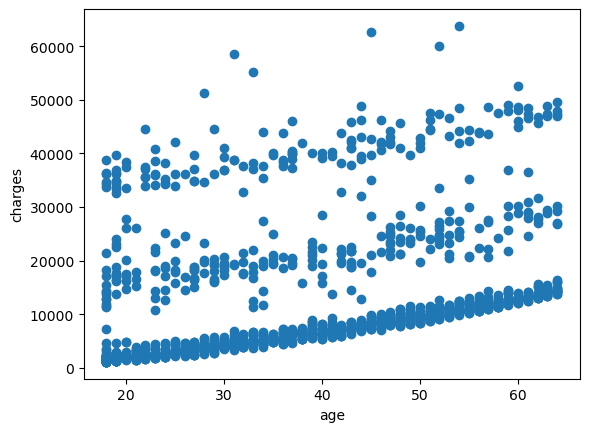

In [38]:
plt.xlabel("age")
plt.ylabel("charges")
plt.scatter(df["age"],df["charges"])
plt.show()

可以觀察出來，年齡與健保費用，存在著些許的線性關係！接著再確認類別變數的影響，可以在上面那張圖標上顏色：

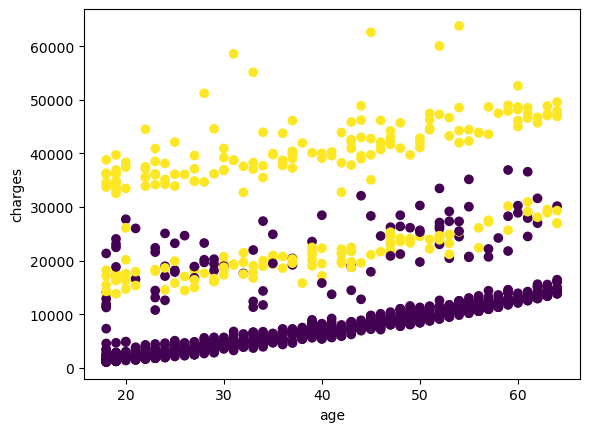

In [40]:
plt.xlabel("age")
plt.ylabel("charges")
plt.scatter(df["age"],df["charges"], c =x["smoker_yes"] )

透過顏色，我們可以直觀地看出吸菸者是否會有較高的醫療費用。plt.scatter() 會自動幫我們設定顏色，不需要手動指定。

檢查已經做過的One-Hot Encoding的欄位 

In [43]:
print(x.columns)

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')


接下來的程式碼的，目的是繪製「吸菸者 vs. 非吸菸者」的醫療費用 (charges) 盒鬚圖，讓我們可以比較這兩組人的醫療費用分布情況。

C:\Users\sarah\AppData\Local\Temp\ipykernel_7488\2924321856.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


{'whiskers': [<matplotlib.lines.Line2D at 0x22103981c10>,
 'caps': [<matplotlib.lines.Line2D at 0x221038c4830>,
 'boxes': [<matplotlib.lines.Line2D at 0x221039813d0>,
 'medians': [<matplotlib.lines.Line2D at 0x221038c62a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x221038c6240>,
 'means': []}

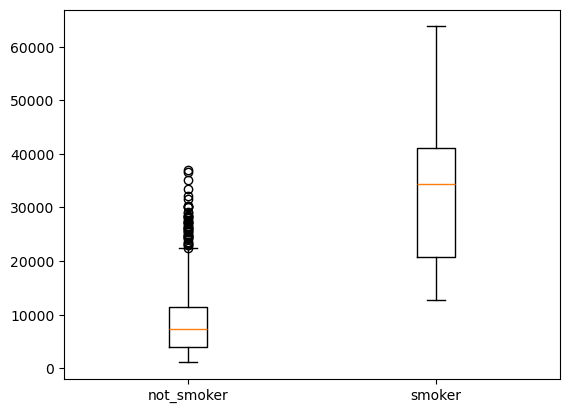

In [45]:
plt.boxplot([
    df[x["smoker_yes"] == 0] ["charges"],
    df[x["smoker_yes"] == 1] ["charges"]
], labels = ['not_smoker', 'smoker'])

3.迴歸分析

用來研究變數之間的關係，特別是 一個或多個「自變數」（X）對「因變數」（Y）的影響。

迴歸類型有自己適用的情境
1.線性迴歸:Y和X 呈現直線關係，適合預測房價、收入、銷售額等數值。
2.多元線性迴歸:用於Y受到多個X影響，例如房價受面積、地點影響。
3.多項式迴歸:用於Y和X有曲線關係的時候，適合股價、溫度變化等。
4.邏輯斯迴歸:Y用於分類問題（0/1），適合預測疾病、信用違約等。
5.Ridge / Lasso 迴歸:用於當變數過多、容易過擬合時，這兩種方法可以改善模型。
6.決策樹迴歸:用於當X和Y關係複雜、非線性，決策樹可自動分割資料。

In [49]:
import statsmodels.api as sm
from scipy import stats
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


接下來用statsmodel中的普通最小平方法(Ordinary Least Squares, OLS)進行線性回歸分析，並顯示回歸結果摘要。

In [51]:
print(x.dtypes)
print(y.dtypes)

age                   int64
bmi                 float64
children              int64
sex_male               bool
smoker_yes             bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object
float64


In [52]:
x = x.astype(float)
y = y.astype(float)

In [53]:
x = sm.add_constant(x)
est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:14:21   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

從報表中來看，可以獲得許多資訊：

根據p-value，age / bmi / children / smoker_yes / region_southeast 呈現統計顯著，可能代表重要的變數

R-squared: 0.751 ； Adj R-squared: 0.749，表示模型預測能力不錯。

然而，當我們建立出一個線性回歸時，必須要確認其殘差(residual)是否符合下面三個假設：

常態性(Normality)

獨立性(Independence)

變異數同質性(Homogeneity of Variance)

故，首先我們要先從回歸模型中找到殘差的值

殘差指的是 模型預測值 (ŷ) 和實際值 (y) 之間的誤差：
如果殘差沒有明顯的模式，代表模型適合；如果殘差呈現某種趨勢，代表模型可能需要改進。

In [55]:
residuals = est2.resid 
print(residuals.head()) 

0    -8408.789028
1    -1723.050534
2    -2257.526491
3    18229.640447
4    -1725.638186
dtype: float64


在回歸分析中，每個數據點都有：

實際值 (y_actual)：真實觀察到的值
預測值 (y_predicted)：回歸模型計算出來的值
殘差（Residual）就是這兩者的差值

解讀殘差

殘差很接近 0，表示模型的預測結果與真實值接近，預測效果好。
殘差數值很大，表示模型的誤差較大，可能需要改進。
第四個數值 18229.64 明顯比其他殘差值大，可能代表：

有異常值 (Outlier)：某些 y 值遠超出一般範圍。
模型的變數不足，沒有完全解釋 y。

In [73]:
from scipy import stats
shapiro_test = stats.shapiro(est2.resid)
print(shapiro_test)

ShapiroResult(statistic=0.8989446056068922, pvalue=8.384716645406418e-29)


線性回歸 (OLS) 基本假設中會希望：

殘差彼此獨立，不能有系統性的相關性（也就是殘差之間沒有模式）。
如果殘差之間存在關聯（例如前一個殘差影響下一個殘差），那麼回歸模型可能不準確。

Durbin-Watson 檢定 (durbin_watson()) 是專門用來測試「殘差是否獨立」的統計方法。
這個檢定的虛無假設 (H₀) 是：「殘差之間沒有自相關」，也就是說，殘差是獨立的。

In [79]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(est2.resid)
print(dw_stat)

2.0884229986673084


以指標準則來看殘差結果是具獨立性的

變異數同質性假設

變異數同質性（Homoscedasticity）是指：
殘差的變異數應該大致相同，不會隨著 x 變大或變小而改變。
如果殘差的變異數隨 x 變大或變小而變化，則稱為「異質性變異數」(Heteroscedasticity)。

如果變異數不同質（Heteroscedasticity），可能導致：
回歸係數的標準誤 (Standard Error) 可能不準確 → 影響 P 值，影響顯著性檢定
影響信賴區間 (Confidence Interval) → 使預測變得不穩定
影響回歸模型的假設 → 可能需要對數轉換 (log(y)) 來解決問題

In [81]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

test = sms.het_breuschpagan(est2.resid, est2.model.exog)

lzip(name, test)

[('Lagrange multiplier statistic', 121.74360137568986),
 ('p-value', 1.446717553918174e-22),
 ('f-value', 16.628612027375397),
 ('f p-value', 1.14560582463403e-23)]

預測

儘管變異數異質性存在，回歸模型可能不太穩定，但因為目標不是建構一個完美的 OLS 模型，而是練習如何建立回歸模型並進行預測，所以接下來主要進行預測部分的學習

In [83]:
x.head()

,const,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,1.0,19.0,27.900,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,18.0,33.770,1.0,1.0,0.0,0.0,1.0,0.0
2,1.0,28.0,33.000,3.0,1.0,0.0,0.0,1.0,0.0
3,1.0,33.0,22.705,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,32.0,28.880,0.0,1.0,0.0,1.0,0.0,0.0


In [97]:
est2.predict([1, 24, 23.5, 0, 1, 1, 1, 0, 0])   #變數的預測 y 值為 25,561.32

array([25561.31632768])

變數預測值為25,561.32，這代表：
如果某人年齡 24、BMI 23.5、男性、吸菸，住在西北地區，他的健保費用大約是 25,561.32。

結論:
(1)預測發現吸菸與否好像影響 y（健保費用），但「看起來」不夠，我們要用 One-Way ANOVA 來確認。
(2)25,561.32 代表一組特定條件下的預測 y 值，可以拿來跟其他類別的 y 值比較，看是否有明顯的差異。
(3)如果 ANOVA 結果顯示不同類別 y 有顯著差異，表示「這些類別確實影響 y」。

4. 變異數分析 (anova)

經過上述步驟，發現不同類別變數健保費用有所差異。
25,561.32 代表了在特定條件下（可能是吸菸者等）的預測健保費用水平。
如果這個值與其他類別（例如非吸菸者）的預測或實際平均值有顯著差異，ANOVA 就能幫助確認這種差異在統計上是否顯著。
因此選用 ANOVA 檢定，用以假設所有類別的平均值相等（H₀）對比至少有一組不相等（H₁）的情況，去檢驗不同類別變數（例如吸菸狀態或地區）對健保費用是否有顯著影響。

In [101]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [103]:
stats.f_oneway(df.loc[df["smoker"] == "yes", "charges"],
               df.loc[df["smoker"] == "no", "charges"])

F_onewayResult(statistic=2177.614868056519, pvalue=8.271435842182967e-283)

這行使用 scipy.stats.f_oneway() 來執行單因子變異數分析（One-Way ANOVA）。
它的目的是 比較兩組數據的平均數是否顯著不同。
這裡的 兩組數據 是：
第一組 → 吸菸者 (smoker = "yes") 的 charges
第二組 → 非吸菸者 (smoker = "no") 的 charges

ANOVA 的統計檢定假設：
H₀（虛無假設）：吸菸者和非吸菸者的 健保費用 (charges) 平均值相等。
H₁（對立假設）：吸菸者和非吸菸者的 健保費用 (charges) 平均值不相等。

我們可以將結果解讀為：
statistic=2177.61
F 統計量 (F-statistic) = 2177.61
F 值越大，表示兩組的差異越大。
在這裡，F 值非常大，說明吸菸者和非吸菸者的健保費用差異很大。

In [106]:
stats.f_oneway(df.loc[df["sex"] == "male", "charges"],
               df.loc[df["sex"] == "female", "charges"])

F_onewayResult(statistic=4.3997016974374565, pvalue=0.03613272100596256)

上面主要是比較男性 (male) 和女性 (female) 的健保費用平均值是否顯著不同。
可以看到 p-value < 0.05，表示「性別」對健保費用有顯著影響。